High Value Customers Identification

# Project Solution Planning

Churn analytics: 
- Churn (or attrition), in the simplest terms, is when customers leave and stop buying your product or using your service during a defined time frame.

- In order to do keep churn rates as close to zero as possible, companies in nearly every industry need to treat churn as a top priority. If ignored, churn can plateau the growth of any business, even the ones that can gain customers quickly.

## Inputs

1. Problema de Negócio
    - Taxa de churn aumentou nos últimos meses
    - Rankear os clientes com maiores probabilidades de entrar em churn

2. Conjunto de dados
    - Atributos que descrevem os clientes de um determinado banco: ChrunDataset Kaggle

## Output

1. Indicação das pessoas que irão entrar em churn
    - Coluna em tabela com rankeado das pessoas com propensão de entrar em churn
    - Modelo em produção
    
2. Relatório com performance do modelo e respostas das perguntas:
     - Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
     - Qual a Performance do modelo em classificar os clientes como churns?
     - Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
     - Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    

## Tasks

1. Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
    - Calcular taxa atual, somatório da coluna target divido pelo número total de clientes da base
    
2. Qual a Performance do modelo em classificar os clientes como churns?
    - Calculo da performance do modelo
    - Verificar métricas de performance learning to rank
    
3. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
    - Curva lift para comparação do modelo com o status quo da empresa e apresentação do resultado
    - Calcular diferença em reais do modelo
    - Calcular ROI
    - Comparativo entre ROIs

4. Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    - Classificar quais clientes trarão mais retorno para empresa com o incentivo.
    

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import inflection
import matplotlib.pyplot as plt

import missingno as msno


from IPython.core.display    import HTML
from IPython.display         import Image

In [2]:
os.getcwd()

'/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/notebooks'

## Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# def cramer_v( x, y ):
#     cm = pd.crosstab( x, y ).values # Confusion Matrix
#     n = cm.sum()
#     r, k = cm.shape
    
#     chi2 = ss.chi2_contingency( cm )[0]
#     chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
#     kcorr = k - (k-1)**2/(n-1)
#     rcorr = r - (r-1)**2/(n-1)
    
#     return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# def mean_absolute_percentage_error( y, yhat ):
#     return np.mean( np.abs( ( y-yhat ) / y ))

# def mean_percentage_error( y, yhat ):
#     return np.mean( ( y - yhat ) / y )

# def ml_error ( model_name, y, yhat):
#     mae = mean_absolute_error( y,yhat )
#     mape = mean_absolute_percentage_error( y,yhat )
#     rmse = np.sqrt(mean_squared_error( y,yhat ))
    
#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE': mae,
#                           'MAPE': mape,
#                           'RMSE': rmse}, index=[0])

# def cross_validation( x_training, kfold, model_name, model, verbose=False ):
#     mae_list = []
#     mape_list = []
#     rmse_list = []
    
#     for k in reversed( range( 1, kfold+1 ) ):
#         if verbose:
#             print( '\nKFold Number: {}'.format( k ) )
#         # start and end date for validation 
#         start_date_validation = x_training['date'].max() - datetime.timedelta( days=k*6*7)
#         end_date_validation = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

#         # filtering dataset
#         training = x_training[x_training['date'] < start_date_validation]
#         validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

#         # training and validation dataset
#         # training
#         xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#         ytraining = training['sales']

#         # validation
#         xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#         yvalidation = validation['sales']

#         # model
#         m = model.fit( xtraining, ytraining )

#         # prediction
#         yhat = m.predict( xvalidation )

#         # performance
#         m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

#         # store performance of each kfold iteration
#         mae_list.append(  m_result['MAE'] )
#         mape_list.append( m_result['MAPE'] )
#         rmse_list.append( m_result['RMSE'] )

#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
#                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
#                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading Dataset

 - **Source**: https://www.kaggle.com/mervetorkan/churndataset

In [5]:
df_churn_raw = pd.read_csv('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/data/raw/churn.csv', low_memory = False)

In [6]:
df_churn_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

# DATA DISCRIPTION

In [7]:
# copy dataset
df0 = df_churn_raw.copy()

## Rename Columns

In [8]:
cols_old = list(df0)
snakecase = lambda x: inflection.underscore(x)
col_news = list(map(snakecase, cols_old))

# Rename columns
df0.columns = col_news
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [9]:
df0.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

## Data Dimension and Type

In [10]:
print('Number of rows: {}'.format(df0.shape[0]))
print('Number of columns: {}'.format(df0.shape[1]))

Number of rows: 10000
Number of columns: 14


In [11]:
# check columns datatypes
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Check for duplicates

In [12]:
# duplicates 

df0.duplicated(subset='customer_id').sum()

0

## Check NA Values

In [13]:
missing_count = df0.isnull().sum()
value_count = df0.isnull().count()

missing_percentage = round(missing_count/value_count*100, 2)
missing_df = pd.DataFrame({'missing value count': missing_count, 'percentage (%)': missing_percentage })
missing_df

,missing value count,percentage (%)
row_number,0,0.0
customer_id,0,0.0
surname,0,0.0
credit_score,0,0.0
geography,0,0.0
gender,0,0.0
age,0,0.0
tenure,0,0.0
balance,0,0.0
num_of_products,0,0.0


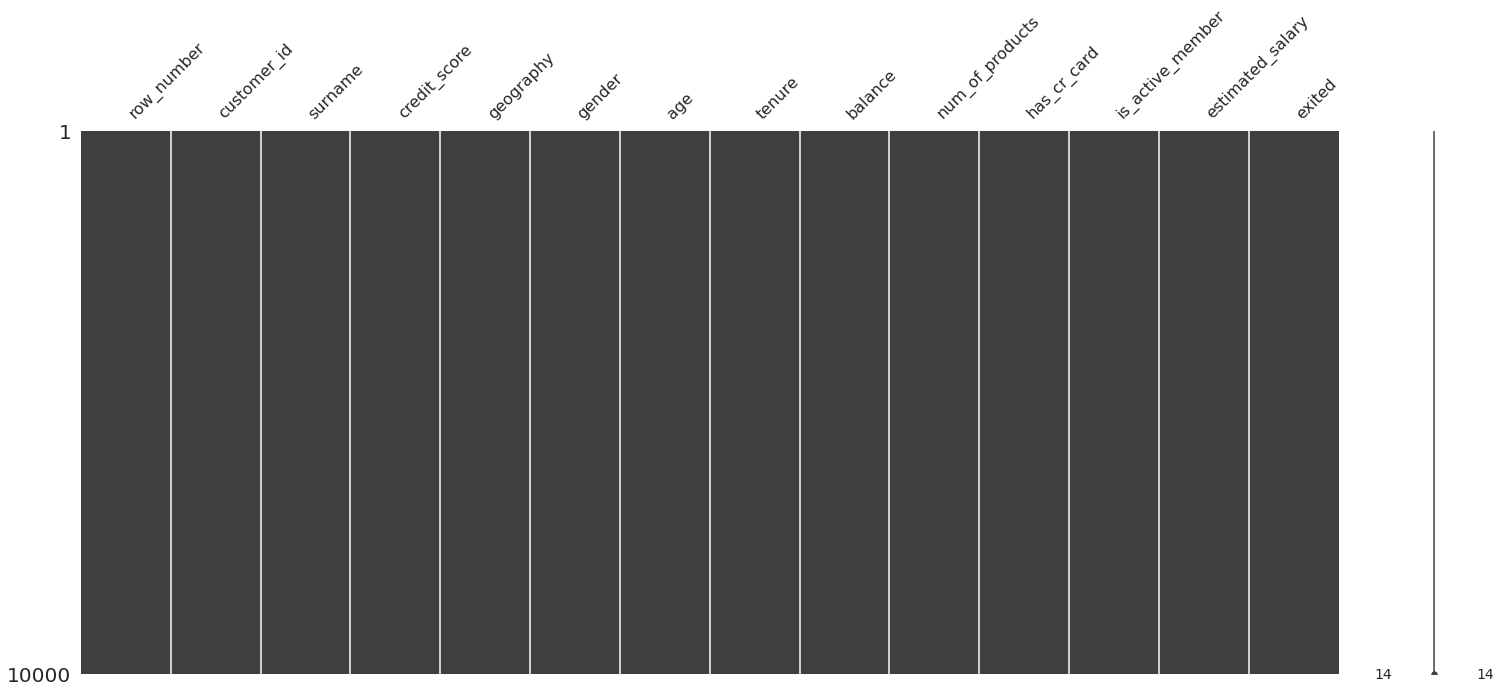

In [14]:
# check no missing values to confirm
msno.matrix(df0);

## Descriptive Statistics

In [15]:
df0.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [16]:
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [17]:
# transforming categorical 1 or 0 values into 'yes' or 'no
col_transform = ['has_cr_card', 'is_active_member']

for col in col_transform:
    df0[col] = df0[col].astype('str') 

for col in col_transform:
    df0[col] = df0[col].apply(lambda x: 'yes' if x=='1' else 'no')


In [18]:
# separate numerical and categorical attributes

num_att = df0.select_dtypes(include = 'number')
cat_att = df0.select_dtypes(include = 'object')

### Numerical Attributes

In [19]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_att.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_att.apply( np.std )).T
d2 = pd.DataFrame(num_att.apply( min )).T
d3 = pd.DataFrame(num_att.apply( max )).T
d4 = pd.DataFrame(num_att.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_att.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_att.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518
8,exited,0.00,1.00,1.00,2.037000e-01,0.000000e+00,0.402748,1.471611,0.165671


In [20]:
num_att.apply( lambda x: x.unique().shape[0])

row_number          10000
customer_id         10000
credit_score          460
age                    70
tenure                 11
balance              6382
num_of_products         4
estimated_salary     9999
exited                  2
dtype: int64

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


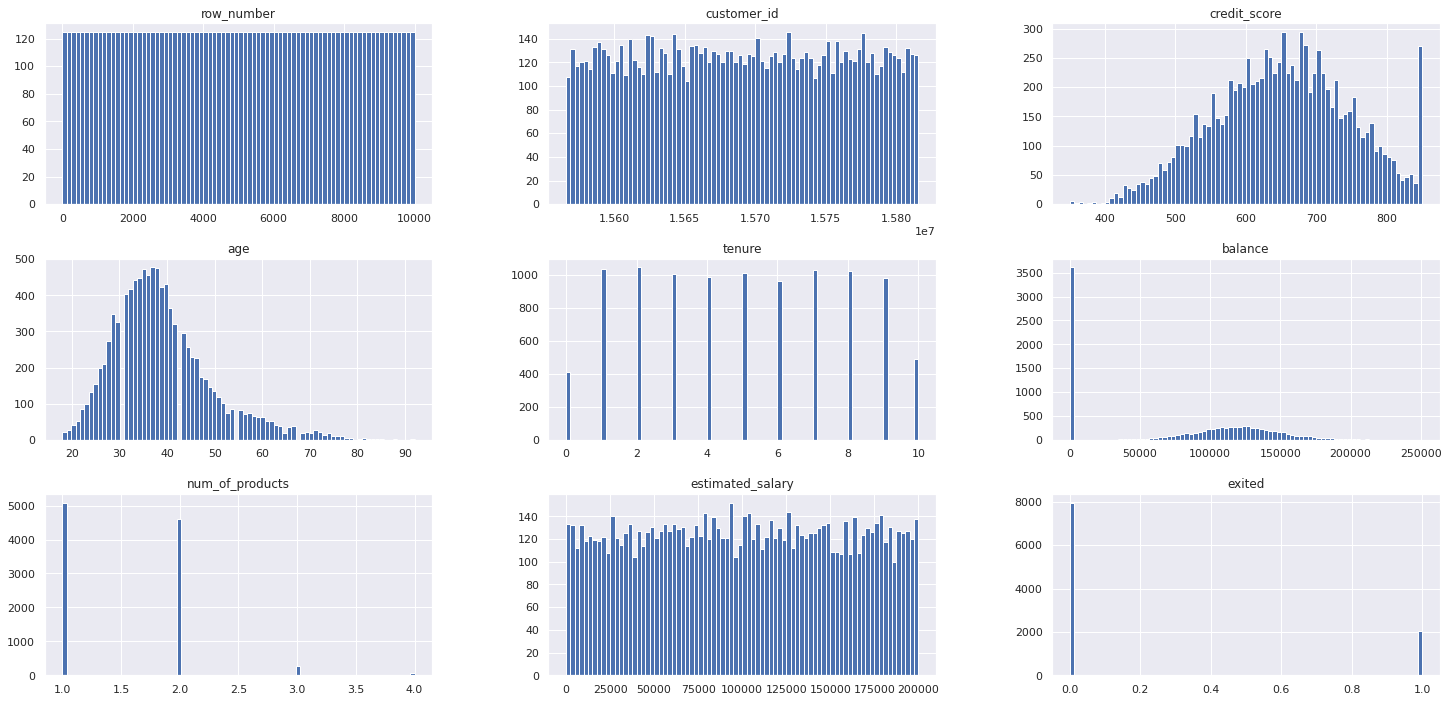

In [21]:
num_att.hist(bins = 80);

 
- Credit score ranges from 350 up to 850. Mean = 650.75. Median = 652.

- Age ranges from 18 up to 92. Mean = 38.95. Median = 37. 75% of the observations are up to the age 44.

- Tenure (number of years that the customer was active) ranges from 0 to 10. Mean = 5.02. Median = 5. 

- According the histogram, the number of customers with tenure equal to zero and 10 is lower than the other tenure values.

- Balance ranges from zero up to 238,387. Mean = 76,381. Median = 97,055. 25% of the observations have value equal to zero.

- Number of products ranges from 1 to 4. Mean = 1.53. Median = 1. 75% of the observations have value equal to 2. The histogram shows that the majority of number of products is 1 and 2. There is no number of products equal to zero, that is, all customers have bought at least one product.

- has_cr_card mean = 0.7087, that is, 70.87% of the observations have has_cr_card equal to 1.

- is_active_member mean = 0.5149, that is, 51.49% of the customers has done a bank activity in the past 12 months.

- Estimated salary ranges from 11.58 up to 199,992. Mean = 99,730. Median = 99,446. The histogram shows that the distribution is similar to an uniform distribution.

- less client in churn, about 20%

### Categorical Attributes

In [22]:
# check unique values of categorical features
cat_att.apply( lambda x: x.unique().shape[0])

surname             2932
geography              3
gender                 2
has_cr_card            2
is_active_member       2
dtype: int64

In [23]:
geo_percentage = df0['geography'].value_counts(normalize = True ) * 100
geo_percentage

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

In [24]:
gender_percentage = df0['gender'].value_counts(normalize = True)*100
gender_percentage

Male      54.57
Female    45.43
Name: gender, dtype: float64

In [25]:
cred_card_percentage = df0['has_cr_card'].value_counts(normalize = True ) * 100
cred_card_percentage

yes    70.55
no     29.45
Name: has_cr_card, dtype: float64

In [26]:
active_member_percentage = df0['is_active_member'].value_counts(normalize = True) * 100
active_member_percentage

yes    51.51
no     48.49
Name: is_active_member, dtype: float64

NameError: name 'exited_percentage' is not defined

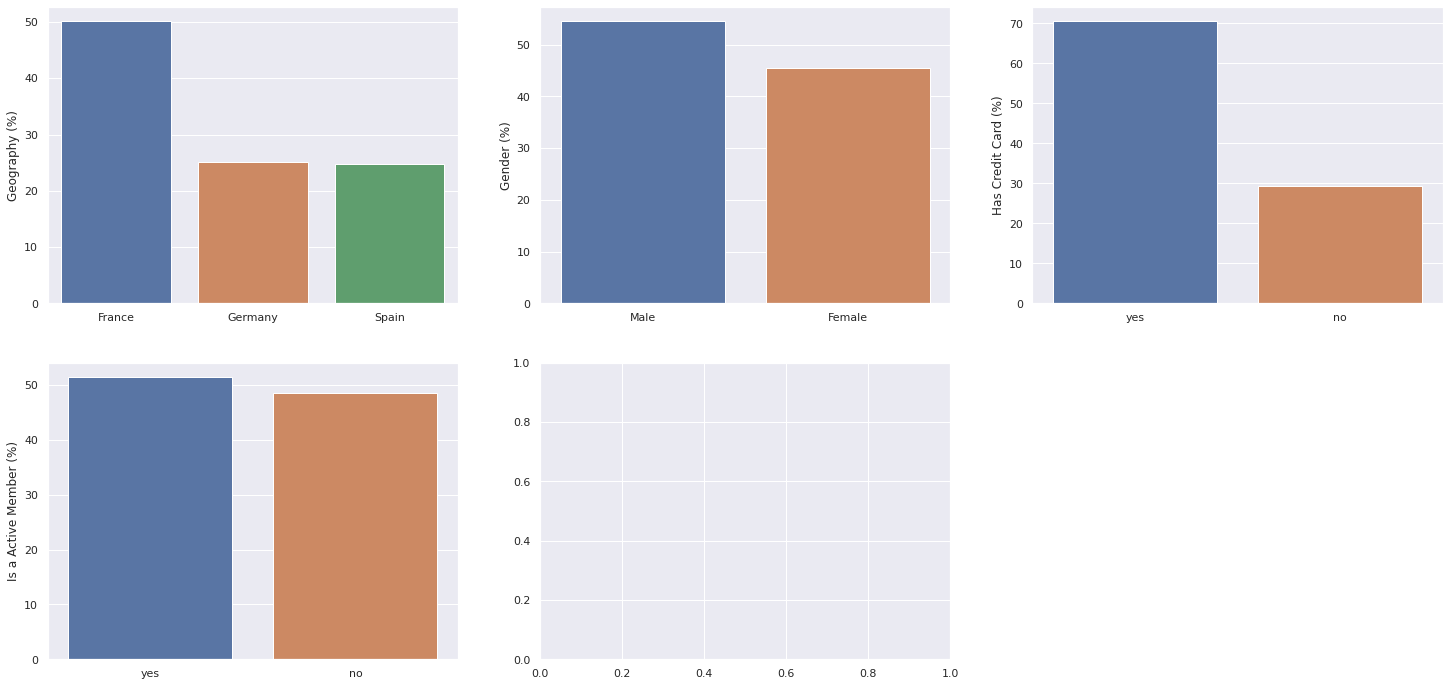

In [27]:
subplot(2, 3, 1)
sns.barplot(x = geo_percentage.index, y = geo_percentage)
plt.ylabel('Geography (%)');

subplot(2, 3, 2)
sns.barplot(x = gender_percentage.index, y = gender_percentage)
plt.ylabel('Gender (%)');

subplot(2, 3, 3)
sns.barplot(x = cred_card_percentage.index, y = cred_card_percentage)
plt.ylabel('Has Credit Card (%)');

subplot(2, 3, 4)
sns.barplot(x = active_member_percentage.index, y = active_member_percentage)
plt.ylabel('Is a Active Member (%)')

# subplot(2, 3, 5)
# sns.barplot(data = df0, x = exited_percentage.index, y = exited_percentage)
# plt.ylabel('%')
# plt.title('Churn Percentage');

### Zero values distribution

 Sometimes the data isn't missing (NaNs), but it can be in a form of an oddly high number of zero values 
 
 **Conclusion**: The 'Balance' columns have a great number of zeros, but it doesn't mean they are missing values (NaNs). Nevertheless, the Data Science team should get in contact with the business team to check if this number is correct

In [28]:
# create DataFrame with zero and non zero values
num_zero = num_att.copy()
num_col = num_zero.columns

for col in num_col :
    num_zero[col] = num_zero[col].apply(lambda x: 'zero' if x==0 else 'not zero')

In [29]:
# check which columns have zero values 
num_zero.apply( lambda x: x.unique().shape[0])

row_number          1
customer_id         1
credit_score        1
age                 1
tenure              2
balance             2
num_of_products     1
estimated_salary    1
exited              2
dtype: int64

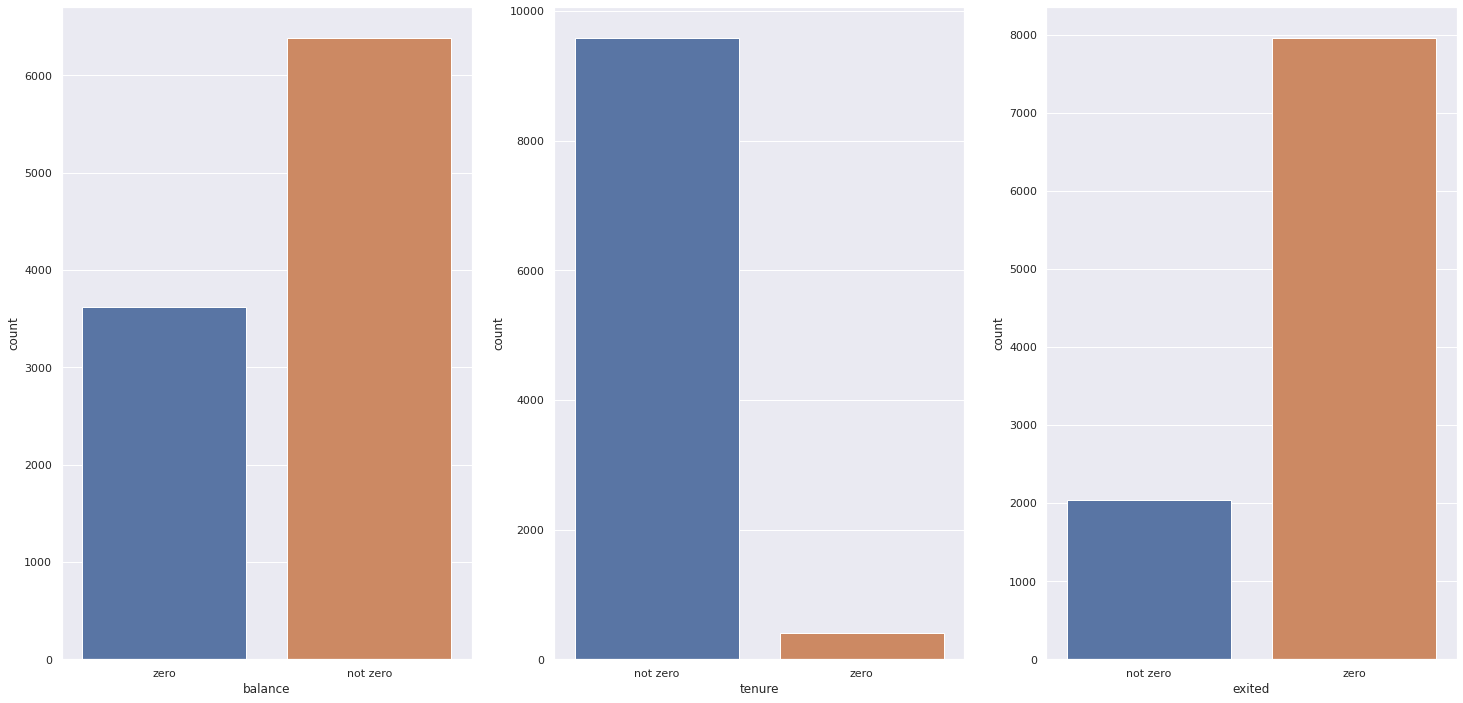

In [30]:
#Plot zero values proportion 
plt.subplot(1,3,1)
sns.countplot(x = 'balance', data = num_zero) 

plt.subplot(1,3,2)
sns.countplot(x = 'tenure', data = num_zero) 

plt.subplot(1,3,3)
sns.countplot(x = 'exited', data = num_zero);

# FEATURE ENGINEERING

In [31]:
# dataset copy
df1 = df0.copy()

## Hypothesis Mindmap

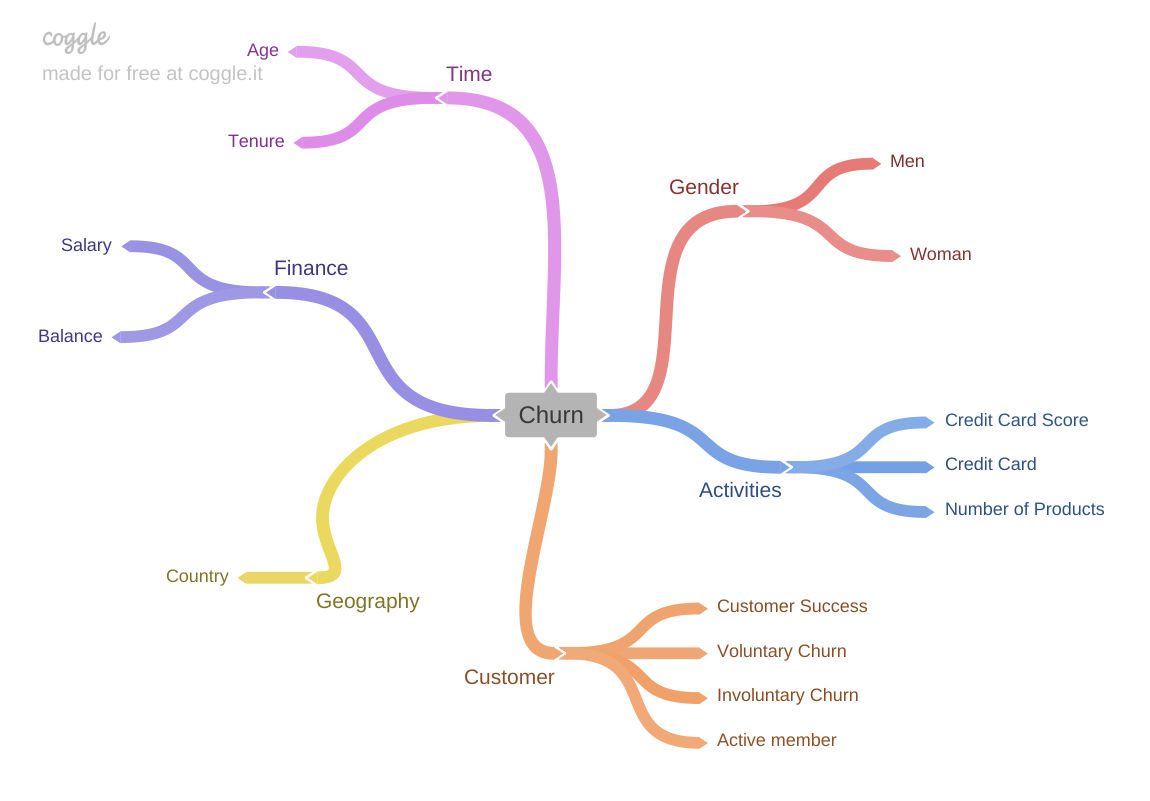

In [32]:
Image('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/reports/figures/Churn.png')

    . The goal of the hypothesis mind-map is to answer questions that are not clear in the dataset. To sum up it's a road map of which analysis do I have to do to validate hypothesis of the business and to which features do I have to create for a better understanding of the data during the Exploratory Data Analysis

Motivação da feature engineering:
    - ter variáveis disponíveis para estudo durante a Análise Exploratória de Dados e o mapa mental ajuda nessa atividade.
    - Um roteiro para mostrar quais análises preciso fazer para validar as hipóteses e quais variáveis precisarei ter para validar as hipóteses
    

In [33]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,yes,yes,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,yes,no,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,no,no,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,0


## Creating Hypothesis

### Finance Hypothesis

- H1. Customers with higher salaries tend to be in churn

- H2. Customers with lower balances tend to be in churn

### Geography Hypothesis

- H3. Customers who live in France tend to be in churn

### Customer Hypothesis

- H4. Active members should not be in churn
- H5. Involuntary churn rate is grater than voluntary churn rate

### Activities Hypothesis

- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more

### Gender Hypothesis

- H9. Womans tend to churn more often than mens

### Time Hypothesis


- H10. Younger costumers tend to churn more often
- H11. Customer with higher tenure tend to have a lower churn rate

## Final Hypothesis List

- H1. Customers with higher salaries tend to be in churn

- H2. Customers with lower balances tend to be in churn

- H3. Customers who live in France tend to be in churn
- H4. Active members should not be in churn
- H5. Involuntary churn rate is grater than voluntary churn rate
- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more
- H9. Womans tend to churn more often than mens
- H10. Younger costumers tend to churn more often
- H11. Customer with higher tenure tend to have a lower churn rate

## Feature Engineering

**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

In [34]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,yes,yes,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,yes,no,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,no,no,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,0


In [35]:
# create features

df1['tenure_year'] = df1['tenure'] + 1

df1['age_by_tenure'] = df1['age'] / df1['tenure_year']

df1['salary_by_credit'] = df1['estimated_salary'] / df1['credit_score']

df1['salary_by_age'] = df1['estimated_salary'] / df1['age']

df1['salary_by_tenure'] = df1['estimated_salary'] / df1['tenure_year']

df1['balance_by_age'] = df1['balance'] / df1['age']

df1['balance_by_prod'] = df1['balance'] / df1['num_of_products']

df1['all_money'] = df1['estimated_salary'] + df1['balance']

df1['money_by_credit'] = df1['all_money'] / df1['credit_score']

In [ ]:
# # reorder columns

# df1 = df1[['row_number',
#  'customer_id',
#  'surname',
#  'credit_score',
#  'geography',
#  'gender',
#  'age',
#  'tenure',
#  'balance',
#  'num_of_products',
#  'has_cr_card',
#  'is_active_member',
#  'estimated_salary',
#  'age_by_tenure',
#  'salary_by_age',
#  'balance_by_age',
#  'balance_by_prod',
#  'salary_by_credit',
#  'all_money',
#  'money_by_credit','exited']]

In [36]:
list(df1)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'tenure_year',
 'age_by_tenure',
 'salary_by_credit',
 'salary_by_age',
 'salary_by_tenure',
 'balance_by_age',
 'balance_by_prod',
 'all_money',
 'money_by_credit']

# VARIABLE FILTERING

In [37]:
df2 = df1.copy()

In [38]:
df2.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,yes,yes,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,yes,no,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,no,no,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


## Line Filtering

## Columns Selection

In [39]:
# feature row_number is not necessary
df2 = df2.drop('row_number', axis = 1)

In [40]:
df2.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,yes,yes,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,15619304,Onio,502,France,Female,42,8,159660.80,3,yes,no,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,15701354,Boni,699,France,Female,39,1,0.00,2,no,no,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


# EXPLORATORY DATA ANALYSIS (EDA)

In [115]:
df3 = df2.copy()

## Univariate Analysis

### Response Variable

In [116]:
exited_percentage = df3['exited'].value_counts(normalize = True)*100
exited_percentage

0    79.63
1    20.37
Name: exited, dtype: float64

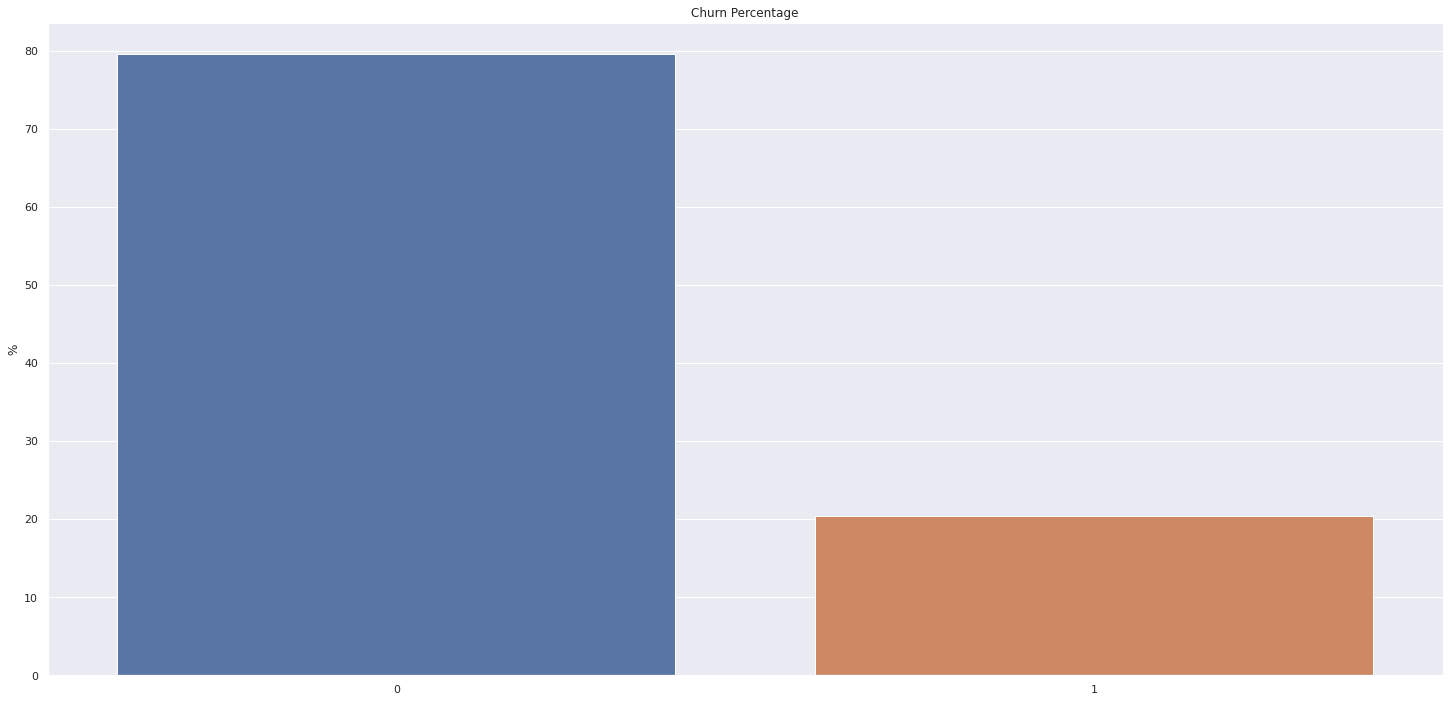

In [43]:
sns.barplot(data = df3, x = exited_percentage.index, y = exited_percentage)
plt.ylabel('%')
plt.title('Churn Percentage');

- 20% of the clients in this dataset are in churn

### Numerical Variable

In [117]:
# separate numerical and categorical attributes
num_att = df3.select_dtypes(include = 'number')

In [45]:
list(num_att)

['customer_id',
 'credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'estimated_salary',
 'exited',
 'tenure_year',
 'age_by_tenure',
 'salary_by_credit',
 'salary_by_age',
 'salary_by_tenure',
 'balance_by_age',
 'balance_by_prod',
 'all_money',
 'money_by_credit']

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


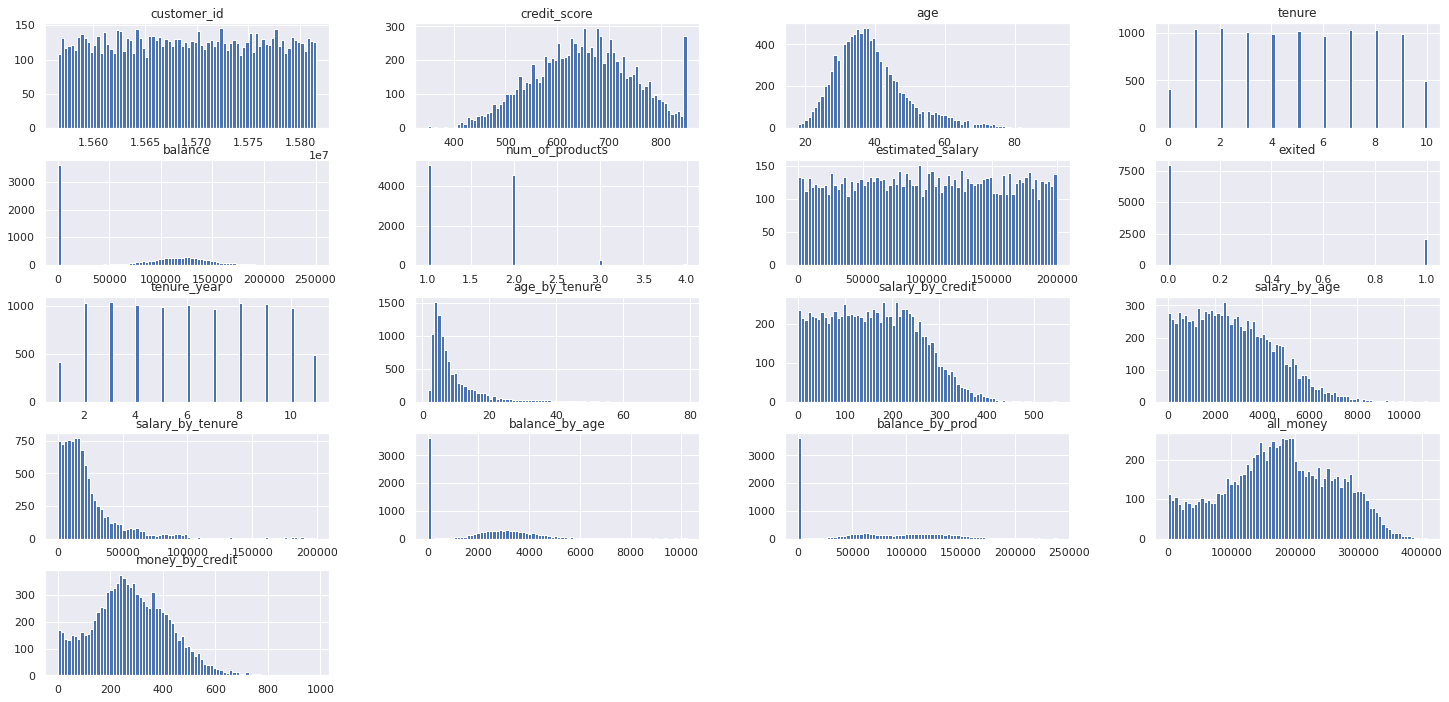

In [46]:
num_att.hist(bins = 80);

#### Credit Score

In [118]:
# credit score
# credit scores from 580 to 669 are considered fair; 670 to 739 are considered good;
# 740 to 799 are considered very good; and 800 and up are considered excellent.
aux_cred = df3[['credit_score', 'exited']].copy()
aux_cred['credit_score_cat'] = df3['credit_score'].apply(lambda x: 'bad' if x < 580 else
                                                              'fair' if (x >= 580 ) & (x < 669) else
                                                              'good' if (x >= 699) & (x < 739) else
                                                              'very good' if (x >= 739) & (x < 799)
                                                               else 'excellent')

aux_cred = aux_cred[['credit_score', 'credit_score_cat', 'exited']]

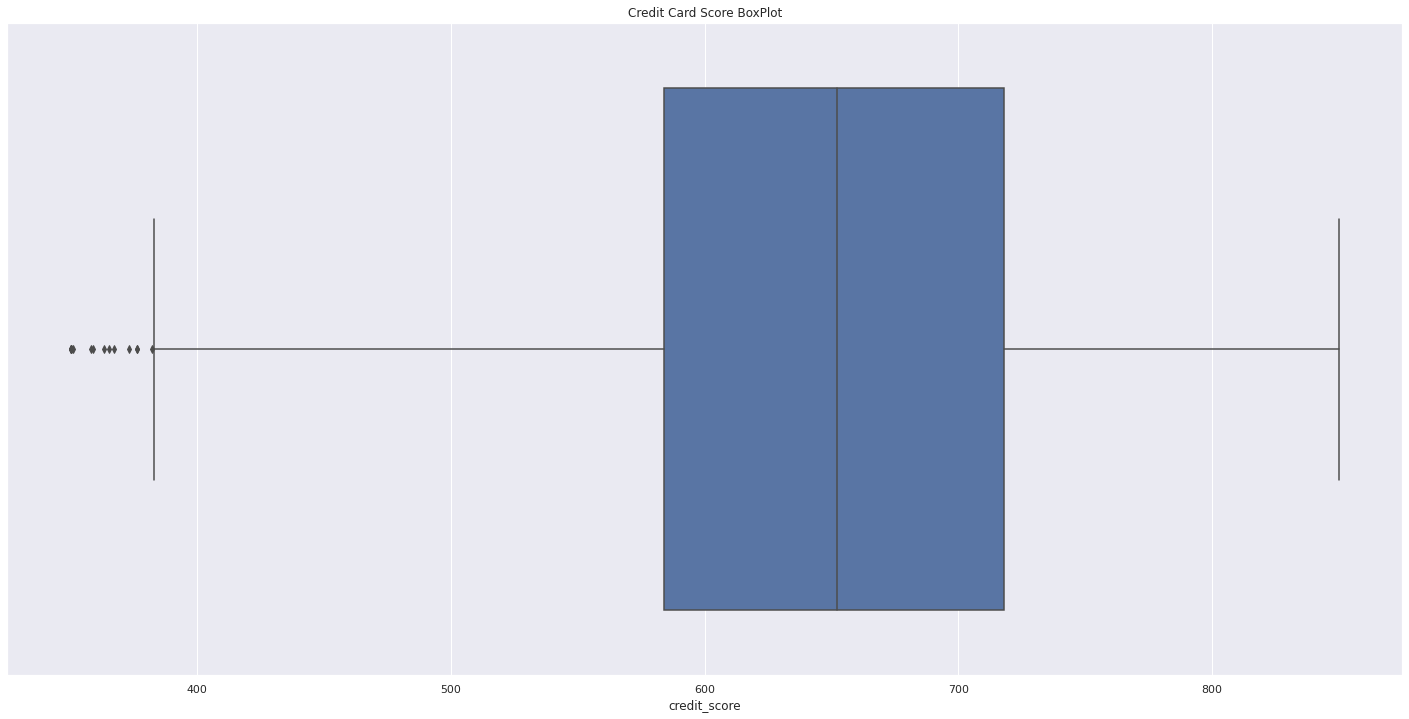

In [48]:
# credit score
sns.boxplot( x = 'credit_score', data = df3)
plt.title('Credit Card Score BoxPlot');

In [49]:
aux_cred.head()

,credit_score,credit_score_cat,exited
0,619,fair,1
1,608,fair,0
2,502,bad,1
3,699,good,0
4,850,excellent,0


In [50]:
aux_cred[aux_cred['credit_score'] < 400]

,credit_score,credit_score_cat,exited
7,376,bad,1
942,376,bad,1
1193,363,bad,1
1201,399,bad,1
1405,359,bad,1
1631,350,bad,1
1838,350,bad,1
1962,358,bad,1
2473,351,bad,1
2579,365,bad,1


In [51]:
aux_cred[aux_cred['credit_score'] < 400].count()

credit_score        19
credit_score_cat    19
exited              19
dtype: int64

- Credit card attribute has some outliers below 400 (a very bad credit card score)
- All these costumers have exited 

#### Age

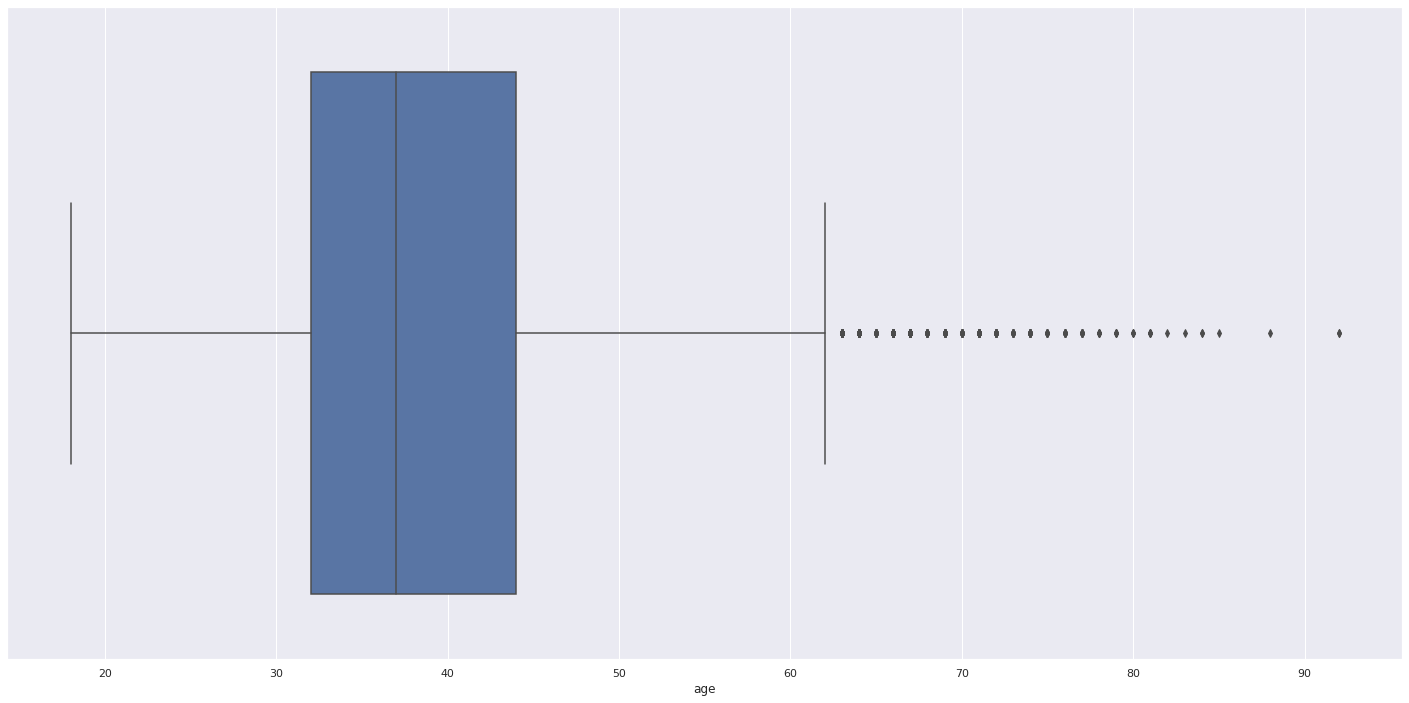

In [52]:
sns.boxplot( x = 'age', data = df3);

### Categorical Variable

In [119]:
cat_att = df3.select_dtypes(include = 'object')
cat_att.head()

,surname,geography,gender,has_cr_card,is_active_member
0,Hargrave,France,Female,yes,yes
1,Hill,Spain,Female,no,yes
2,Onio,France,Female,yes,no
3,Boni,France,Female,no,no
4,Mitchell,Spain,Female,yes,yes


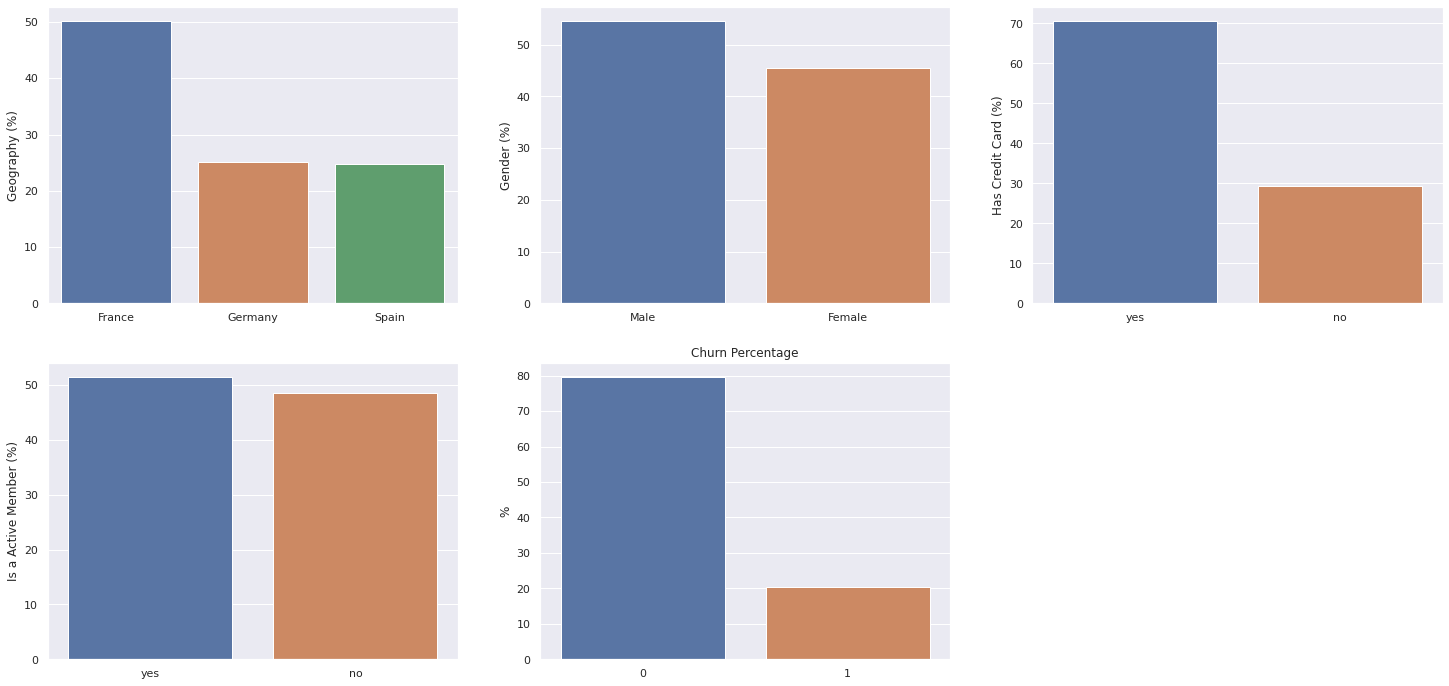

In [54]:
subplot(2, 3, 1)
sns.barplot(x = geo_percentage.index, y = geo_percentage)
plt.ylabel('Geography (%)');

subplot(2, 3, 2)
sns.barplot(x = gender_percentage.index, y = gender_percentage)
plt.ylabel('Gender (%)');

subplot(2, 3, 3)
sns.barplot(x = cred_card_percentage.index, y = cred_card_percentage)
plt.ylabel('Has Credit Card (%)');

subplot(2, 3, 4)
sns.barplot(x = active_member_percentage.index, y = active_member_percentage)
plt.ylabel('Is a Active Member (%)')

subplot(2, 3, 5)
sns.barplot(data = df3, x = exited_percentage.index, y = exited_percentage)
plt.ylabel('%')
plt.title('Churn Percentage');

## Bivariate Analysis

In [55]:
df3.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,yes,yes,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,no,yes,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,15619304,Onio,502,France,Female,42,8,159660.80,3,yes,no,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,15701354,Boni,699,France,Female,39,1,0.00,2,no,no,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


### H1. Customers with higher salaries tend to be in churn

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


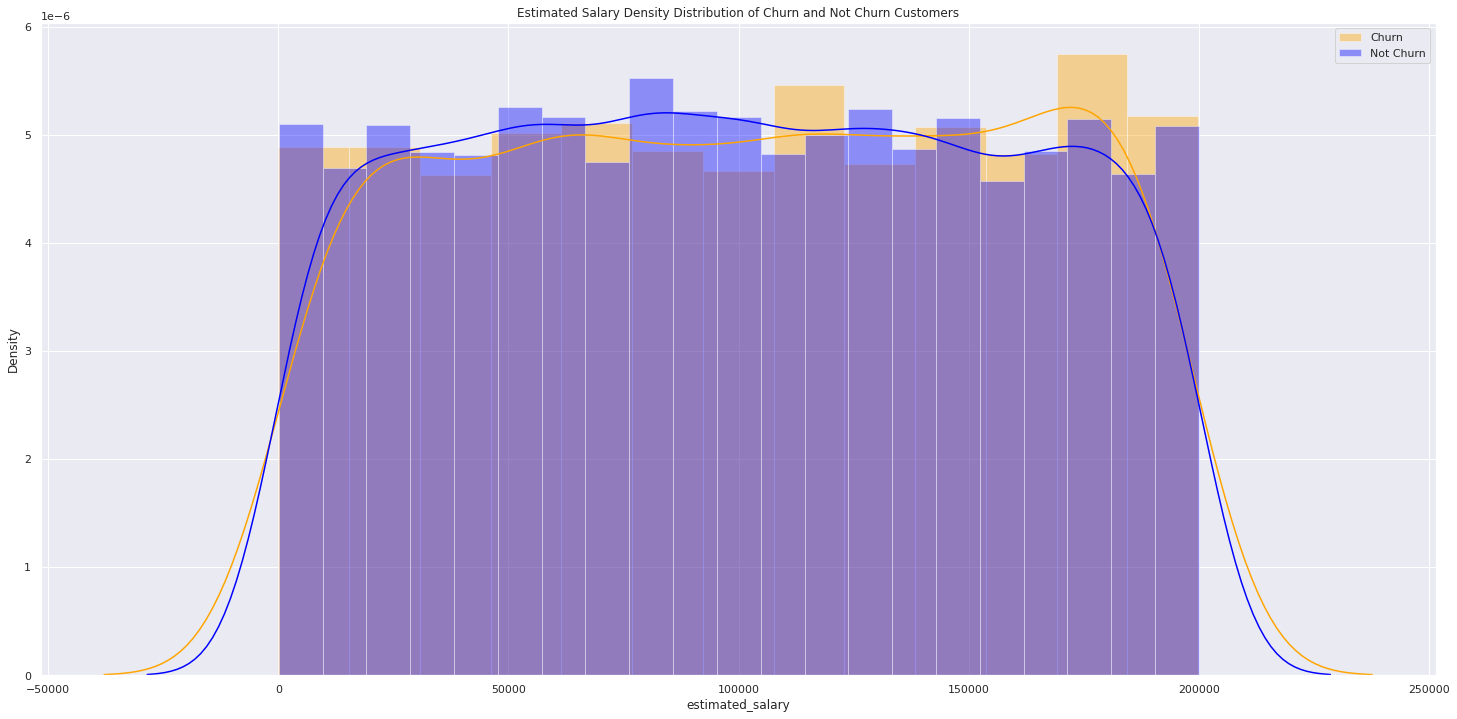

In [120]:
# auxiliary dataframe for exited = 0 and = 1
aux_exited0 = df3[df3['exited'] == 0]
aux_exited1 = df3[df3['exited'] == 1]

# plot estimated salary density distribution for exited = 0 and 1
sns.distplot(aux_exited1['estimated_salary'], color = 'orange', kde = True, label = 'Churn')
sns.distplot(aux_exited0['estimated_salary'], color = 'blue', kde = True, label = 'Not Churn')
plt.title('Estimated Salary Density Distribution of Churn and Not Churn Customers');
plt.legend();

In [82]:
a = df0.groupby('exited')['estimated_salary'].sum().reset_index()
a

,exited,estimated_salary
0,0,7.942168e+08
1,1,2.066856e+08


In [121]:
# Estimated Salary Describe - Not Churn and Churn
a = df3.groupby('exited')['estimated_salary'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a = a.T
a.columns = ['Not Churn', 'Churn']
a

,Not Churn,Churn
count,7963.000000,2037.000000
mean,99738.391772,101465.677531
median,99645.040000,102460.840000
std,57405.586966,57912.418071
min,90.070000,11.580000
max,199992.480000,199808.100000


<ipython-input-134-bfefe0547b46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_exited0['salary_category'] = pd.cut(aux_exited0['estimated_salary'], bins = bins)
<ipython-input-134-bfefe0547b46>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_exited1['salary_category'] = pd.cut(aux_exited1['estimated_salary'], bins = bins)


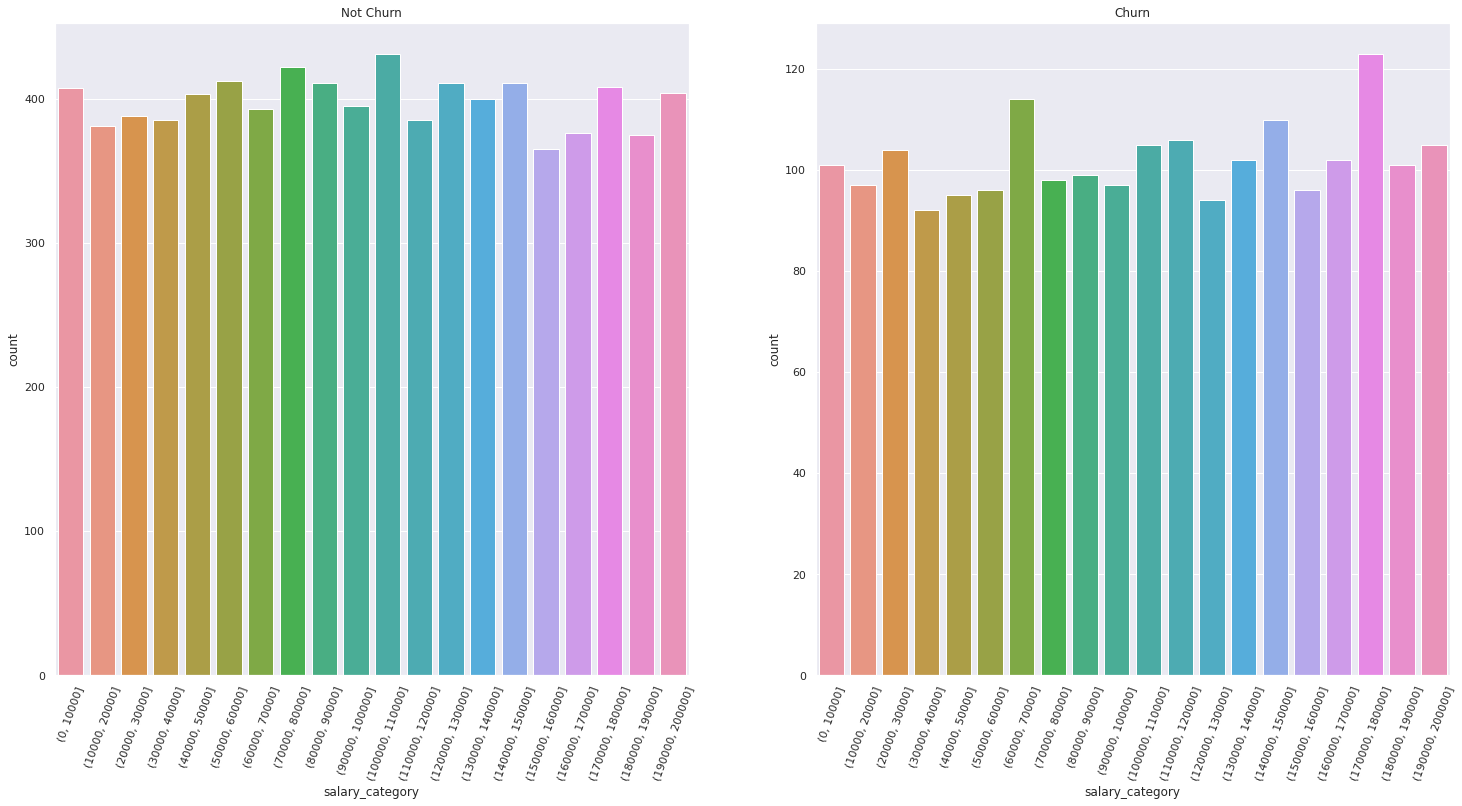

In [134]:
# Create Estimate Salary Categories
bins = list(np.arange(0,210000, 10000))
aux_exited0['salary_category'] = pd.cut(aux_exited0['estimated_salary'], bins = bins)
aux_exited1['salary_category'] = pd.cut(aux_exited1['estimated_salary'], bins = bins)

subplot(1, 2, 1)
sns.countplot(x = 'salary_category', data = aux_exited0).set_title('Not Churn')
plt.xticks(rotation = 70)

subplot(1, 2, 2)
sns.countplot(x = 'salary_category', data = aux_exited1).set_title('Churn')
plt.xticks(rotation = 70);

In [142]:
# Create Relative Salaray Percentage Count plot, since the salary count of 
#churn and not churn clients are too different

bins = list(np.arange(0,210000, 20000))

# create new dataframe
aux1 = df3[['estimated_salary', 'exited']]
aux1['salary_category'] = pd.cut(aux1['estimated_salary'], bins = bins)

# new dataframe with salary_category, exited, and number of clients 
aux10 = aux1[['salary_category', 'estimated_salary', 'exited']].groupby(['salary_category', 'exited']).count().reset_index()

# rename dataframe columns
aux10.columns = ['salary_category', 'exited', 'number_of_clients']

# sum of clients in churn
clients_churn = aux10[aux10['exited'] == 1]['number_of_clients'].sum()

# sum of clients not in churn
clients_not_churn = aux10[aux10['exited'] == 0]['number_of_clients'].sum()

# calculate the relative percentage ratio of clients not or in churn
aux10['relative_percentage'] = aux10.apply(lambda x: (x['number_of_clients']/clients_churn)*100 if 'exited' == 1 else (x['number_of_clients']/clients_not_churn)*100, axis = 1 )

aux10.head(30)


<ipython-input-142-8a1e2d759a24>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['salary_category'] = pd.cut(aux1['estimated_salary'], bins = bins)


,salary_category,exited,number_of_clients,relative_percentage
0,"(0, 20000]",0,788,9.895768
1,"(0, 20000]",1,198,2.486500
2,"(20000, 40000]",0,773,9.707397
3,"(20000, 40000]",1,196,2.461384
4,"(40000, 60000]",0,815,10.234836
5,"(40000, 60000]",1,191,2.398593
6,"(60000, 80000]",0,815,10.234836
7,"(60000, 80000]",1,212,2.662313
8,"(80000, 100000]",0,806,10.121813
9,"(80000, 100000]",1,196,2.461384


In [143]:
clients_churn

2037

In [144]:
clients_not_churn

7963

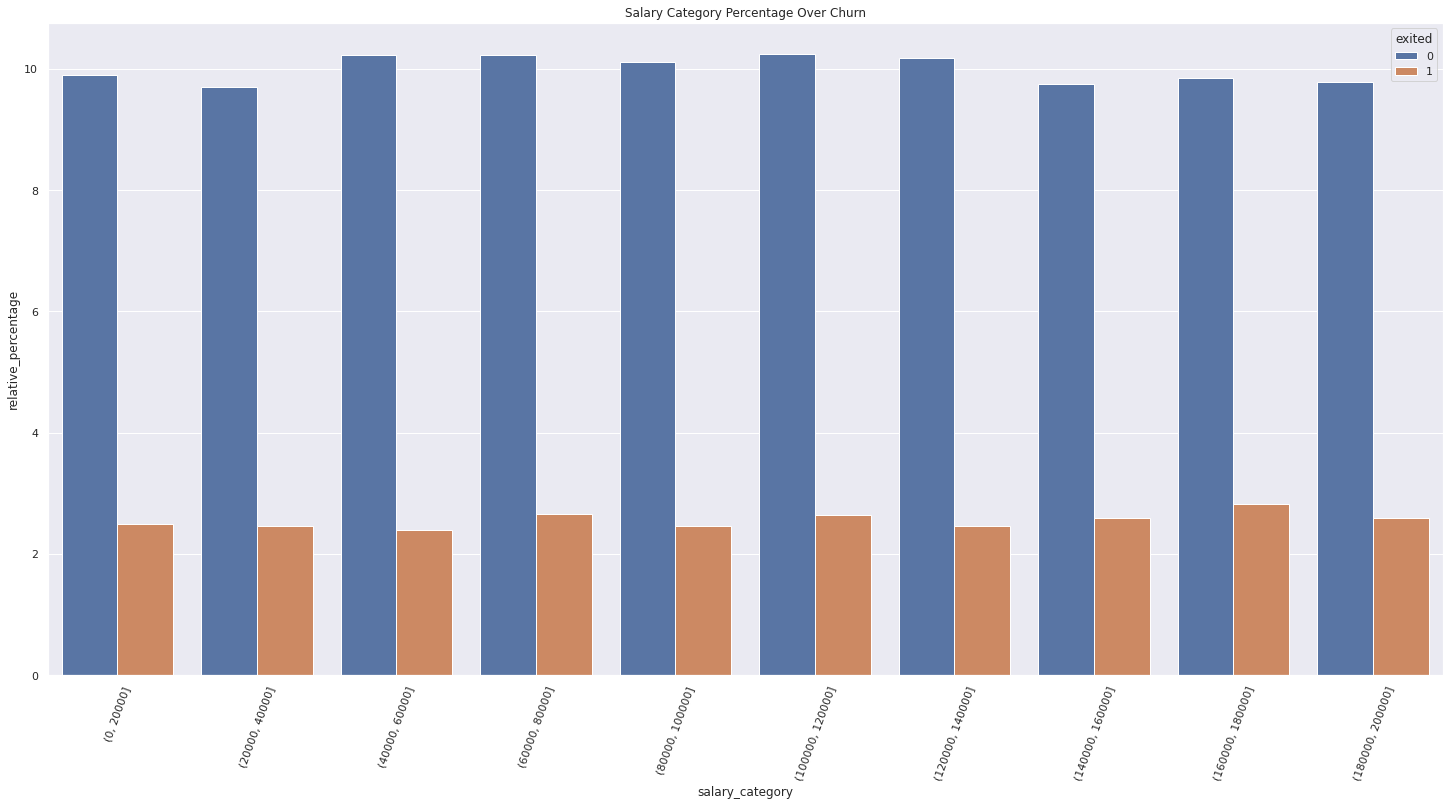

In [141]:
sns.barplot(x = 'salary_category', y = 'relative_percentage' ,data = aux10, hue = 'exited').set_title('Salary Category Percentage Over Churn')
plt.xticks(rotation = 70);

In [84]:
sns.countplot(x = 'estimated_salary', data = aux_exited0)

<AxesSubplot:xlabel='estimated_salary', ylabel='count'>

Error in callback <function flush_figures at 0x7ff0f1844d30> (for post_execute):


KeyboardInterrupt: 

### H2. Customers with lower balances tend to be in churn

### H3. Customers who live in France tend to be in churn

### H4. Active members should not be in churn

### H5. Involuntary churn rate is grater than voluntary churn rate

### H6. Customers with credit card have more probability to churn

### H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)

### H8. Customers with less products tend to churn more

### H9. Womans tend to churn more often than mens

### H10. Younger costumers tend to churn more often

### H11. Customer with higher tenure tend to have a lower churn rate

- H1. Customers with higher salaries tend to be in churn

- H2. Customers with lower balances tend to be in churn

- H3. Customers who live in France tend to be in churn
- H4. Active members should not be in churn
- H5. Involuntary churn rate is grater than voluntary churn rate
- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more
- H9. Womans tend to churn more often than mens
- H10. Younger costumers tend to churn more often
- H11. Customer with higher tenure tend to have a lower churn rate

## Multivariate Analysis

# DATA PREPARATION

## Feature Normalization

## Feature Rescaling

## Feature Transformation

### Enconding

### Target Variable Transformation

### Nature Transformation

# FEATURE SELECTION

## Spliting dataframe into training and test dataset

## Feature Selector (boruta?)

## Best Features

# MACHINE LEARNING ALGORITHM MODELS

## Modelo 1

## Modelo 2

## Modelo 3

## Compare Model's Performance

# HYPERPARAMETERS FINE TUNING

# ERROR INTERPRETATION

# MODEL DEPLOYMENT